In [14]:
import numpy as np, pandas as pd
import sys, os
import time, datetime
import random
import matplotlib.pyplot as plt
from scipy import stats
import pyomo.environ
from pyomo.core import *
from pyomo.opt import SolverFactory

# Minority majority sim for 2020 census DP

from Abie's sim: \
illustration of the minority minority areas pulling the minority majority counts down after nonneg optimization

In [2]:
# function to add geometric noise to counts
def GDPC(eps, exact_counts):
        """ Geometric DP Counts
        Parameters
        ----------
        eps : float-able
        exact_counts : pd.Series

        Results
        -------
        returns dp_counts, a pd.Series with index matching exact_counts"""

        z = float(eps)

        all_errors = (np.random.geometric(z, size=len(exact_counts))
                        - np.random.geometric(z, size=len(exact_counts)))
        dp_counts = exact_counts + all_errors
        return dp_counts

In [3]:
# function to generate final synthetic counts
def nonnegative_optimize(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative

    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float

    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts)

    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum((model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.sum_constraint = Constraint(
        expr=summation(model.x) == control_total)

    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]

    return np.array(optimized_counts)

In [4]:
#set random seed
np.random.seed(2)

#set privacy budget
epsilon = '0.1'

#parameters for distribution of county sizes (beta)
a = .02
b = 10
K = 10_000

#parameters for distribution of pct minority per county
pct_minority = .05
segregation_factor = 1

In [5]:
#create distribution of county sizes
n_k = np.random.beta(a, b, K) # number of individuals in area k
n_k *= 3e3
total_pop = sum(n_k)
print(f'total pop: {total_pop}')

total pop: 59716.71508518248


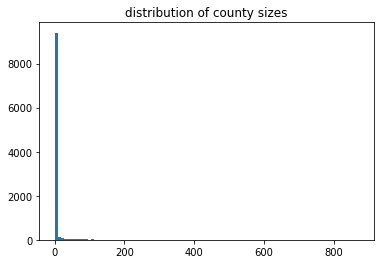

In [6]:
plt.hist(n_k, bins = 100)
plt.title("distribution of county sizes")
plt.show()

In [7]:
minority_share = np.random.beta(pct_minority/segregation_factor,
                                (1-pct_minority)/segregation_factor, size=K)

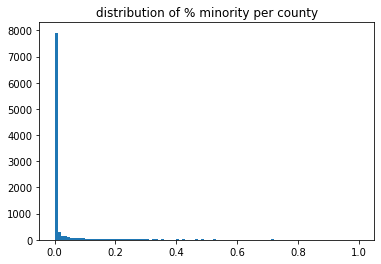

In [8]:
plt.hist(minority_share, bins = 100)
plt.title("distribution of % minority per county")
plt.show()

In [9]:
# simulate race-/location-stratified counts
precise_minority_count = np.random.binomial(n_k.astype(int), minority_share)
precise_majority_count = n_k - precise_minority_count

In [10]:
print(f'overall minority percentage: ',precise_minority_count.sum()/total_pop)

overall minority percentage:  0.043337949790244926


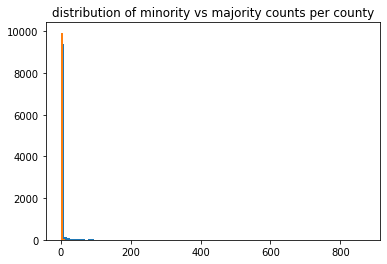

In [11]:
plt.hist(precise_majority_count, bins = 100)
plt.hist(precise_minority_count, bins = 100)
plt.title("distribution of minority vs majority counts per county")
plt.show()

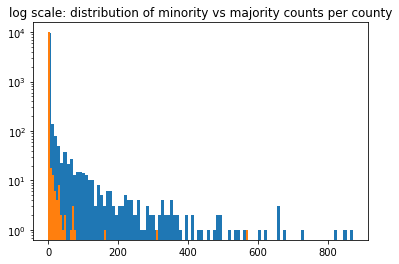

In [12]:
plt.hist(precise_majority_count, bins = 100, log=True)
plt.hist(precise_minority_count, bins = 100, log=True)
plt.title("log scale: distribution of minority vs majority counts per county")
plt.show()

In [13]:
# add Geometric noise, to make counts differentially private
dp_minority_count = GDPC(epsilon, precise_minority_count)
dp_majority_count = GDPC(epsilon, precise_majority_count)

# optimize to find counts that are "close" to the dp counts,
# are non-negative, and have race-stratified sums that match the precise t
# total sum for both minority and majority
nn_minority_count = nonnegative_optimize(dp_minority_count, precise_minority_count.sum())
nn_majority_count = nonnegative_optimize(dp_majority_count, precise_majority_count.sum())

KeyboardInterrupt: 

In [ ]:
minority_majority_area = (minority_share > .5)
min_min_area = (minority_share <= .5)

In [ ]:
print(f'precise minority count in minority majority areas: ',precise_minority_count[minority_majority_area].sum())
print(f'precise minority count in minority minority areas: ',precise_minority_count[minority_share <= .5].sum())

In [ ]:
print(f'dp minority count in minority majority areas: ',dp_minority_count[minority_majority_area].sum())
print(f'dp minority count in minority minority areas: ',dp_minority_count[minority_share <= .5].sum())

In [ ]:
print(f'sum of minority negatives in min maj areas: ',dp_minority_count[(minority_majority_area) & (dp_minority_count < 1)].sum())
print(f'sum of minority negatives in min min areas: ',dp_minority_count[(min_min_area) & (dp_minority_count < 1)].sum())

In [ ]:
print(f'''nn minority count in minority majority areas: {nn_minority_count[minority_majority_area].sum()},
nn minority count in minority minority areas: {nn_minority_count[minority_share <= .5].sum()}''')

In [ ]:
mma_count = minority_majority_area.sum()
print(f'''minority majority areas
precise {precise_minority_count[minority_majority_area].sum()}, mean {precise_minority_count[minority_majority_area].sum()/mma_count},
     dp {dp_minority_count[minority_majority_area].sum()}, mean {dp_minority_count[minority_majority_area].sum()/mma_count},
non-neg {nn_minority_count[minority_majority_area].sum()}, mean {nn_minority_count[minority_majority_area].sum()/mma_count}''')
print(f'pct diff {1-(nn_minority_count[minority_majority_area].sum()/precise_minority_count[minority_majority_area].sum())}')

In [ ]:
print(f'''minority minority areas
precise {precise_minority_count[min_min_area].sum()}, mean {precise_minority_count[min_min_area].sum()/mma_count},
     dp {dp_minority_count[min_min_area].sum()}, mean {dp_minority_count[min_min_area].sum()/mma_count},
non-neg {nn_minority_count[min_min_area].sum()}, mean {nn_minority_count[min_min_area].sum()/mma_count}''')
print(f'pct diff {1-(nn_minority_count[min_min_area].sum()/precise_minority_count[min_min_area].sum())}')

In [ ]:
plt.hist(dp_minority_count, bins = 100)
plt.hist(dp_minority_count[minority_majority_area], bins = 100)
plt.title("minority dp counts; minority majority areas highlighted")

plt.show()

In [ ]:
plt.hist(dp_minority_count, bins = 100, log = True)
plt.hist(dp_minority_count[minority_majority_area], bins = 100, log = True)
plt.title("minority dp counts")

plt.show()

In [ ]:
plt.hist(dp_majority_count, bins = 100)
plt.title("majority dp counts")

plt.show()

In [ ]:
plt.hist(dp_minority_count[min_min_area], bins = 100, log = True)
plt.hist(dp_minority_count[minority_majority_area], bins = 100, log = True)

plt.show()

In [ ]:
#set random seed
np.random.seed(1)

#set privacy budget
epsilon = '0.1'

#parameters for distribution of county sizes (beta)
a = .02
b = 10
K = 10_000

#parameters for distribution of pct minority per county
pct_minority = .05
segregation_factor = 1

#create distribution of county sizes
n_k = np.random.beta(a, b, K) # number of individuals in area k
n_k *= 3e7
total_pop = sum(n_k)
print(f'total pop: {total_pop}')

# add Geometric noise, to make counts differentially private
dp_minority_count = GDPC(epsilon, precise_minority_count)
dp_majority_count = GDPC(epsilon, precise_majority_count)

# optimize to find counts that are "close" to the dp counts,
# are non-negative, and have race-stratified sums that match the precise t
# total sum for both minority and majority
nn_minority_count = nonnegative_optimize(dp_minority_count, precise_minority_count.sum())
nn_majority_count = nonnegative_optimize(dp_majority_count, precise_majority_count.sum())

In [ ]:
plt.hist(dp_minority_count, bins = 100, log = True)
plt.hist(dp_minority_count[minority_majority_area], bins = 100, log = True)
plt.title("minority dp counts")

plt.show()

In [ ]:
# add constraint on how negative the counts can go

# function to generate final synthetic counts
def nonnegative_optimize_v2(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative

    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float

    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts) + max(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum(abs(model.x[i] - imprecise_counts[i]) for i in model.I))
    model.sum_constraint = Constraint(
        expr=summation(model.x) == control_total)
#     def diff_rule(model, i):
#         return imprecise_counts[i] - model.x[i] <= ((abs(imprecise_counts[i])))
#     model.diff_constraint = Constraint(model.I, rule=diff_rule)


    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]

    return np.array(optimized_counts)

In [ ]:
# optimize to find counts that are "close" to the dp counts,
# are non-negative, and have race-stratified sums that match the precise t

# total sum for both minority and m
nn_minority_count_v2 = nonnegative_optimize_v2(dp_minority_count, precise_minority_count.sum())
nn_majority_count_v2 = nonnegative_optimize_v2(dp_majority_count, precise_majority_count.sum())

In [ ]:
print(f'precise minority count in minority majority areas: ',precise_minority_count[minority_majority_area].sum())
print(f'precise minority count in minority minority areas: ',precise_minority_count[minority_share <= .5].sum())
print(f'dp minority count in minority majority areas: ',dp_minority_count[minority_majority_area].sum())
print(f'dp minority count in minority minority areas: ',dp_minority_count[minority_share <= .5].sum())
print(f'''nn minority count in minority majority areas: {nn_minority_count_v2[minority_majority_area].sum()},
nn minority count in minority minority areas: {nn_minority_count_v2[minority_share <= .5].sum()}''')

In [ ]:
max(list(dp_minority_count))